In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)

TF version: 2.11.0
TFP version: 0.19.0


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy,MeanSquaredError
from tensorflow.keras.optimizers import RMSprop, Adam
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

**Dense Variational**

*Linear Data*

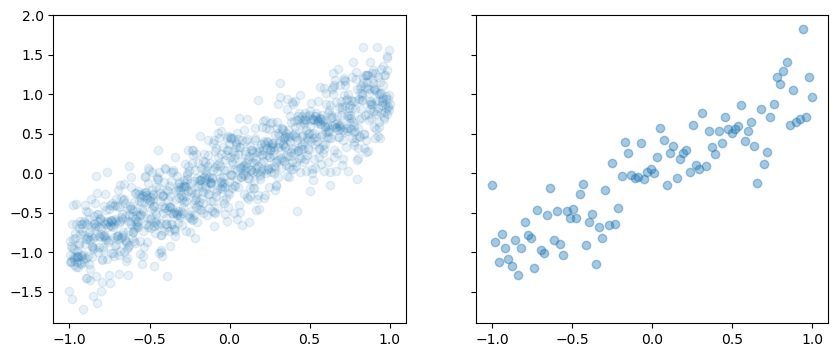

In [3]:
x_train_1000 = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train_1000 = x_train_1000 + 0.3*np.random.randn(1000)[:, np.newaxis]

x_train_100 = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train_100 = x_train_100 + 0.3*np.random.randn(100)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
ax1.scatter(x_train_1000, y_train_1000, alpha=0.1)
ax2.scatter(x_train_100, y_train_100, alpha=0.4)
plt.show()

In [4]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = Sequential([
        tfpl.DistributionLambda(
        lambda t: tfd.MultivariateNormalDiag(loc = tf.zeros(n), scale_diag = tf.ones(n)))
    ])
    return prior_model

In [5]:
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype = dtype),
        tfpl.MultivariateNormalTriL(n)
])
    return posterior_model

*No alleatoric uncertainty (Last layer Deterministic). Only Epistemic ->Dense Variational*

In [6]:
model_1000 = Sequential([tfpl.DenseVariational(input_shape=(1,), 
                                               units=1,
                                               make_prior_fn=prior, 
                                               make_posterior_fn=posterior,
                                               kl_weight=1/1000)])

model_100 = Sequential([tfpl.DenseVariational(input_shape=(1,), 
                                              units=1,
                                              make_prior_fn=prior, 
                                              make_posterior_fn=posterior,
                                              kl_weight=1/100)])

model_1000.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model_100.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))

model_1000.fit(x_train_1000, y_train_1000, epochs=50, verbose=False)
model_100.fit(x_train_100, y_train_100, epochs=500, verbose=False)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


*Plotting an ensemble. Clearly, more data means less uncertainty*

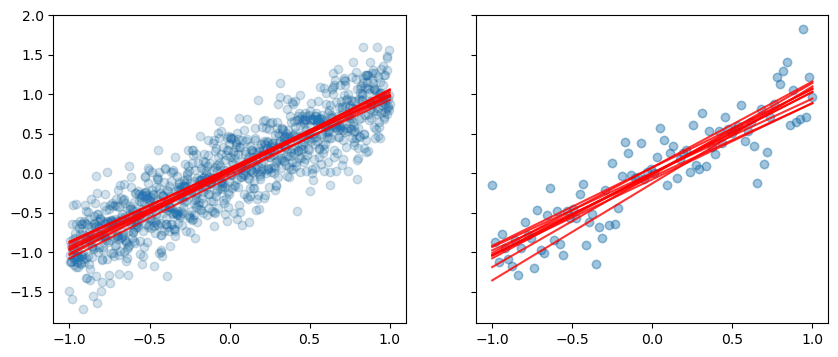

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for _ in range(10):
    y_model_1000 = model_1000(x_train_1000)
    ax1.scatter(x_train_1000, y_train_1000, color='C0', alpha=0.02)
    ax1.plot(x_train_1000, y_model_1000, color='red', alpha=0.8)
    y_model_100 = model_100(x_train_100)
    ax2.scatter(x_train_100, y_train_100, color='C0', alpha=0.05)
    ax2.plot(x_train_100, y_model_100, color='red', alpha=0.8)
plt.show()

*Lets Try Alleatoric and Epistemic*

In [8]:
x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(1000)[:, np.newaxis]

In [10]:
model = Sequential([
    tfpl.DenseVariational(units = 6, 
                         input_shape = (1,),
                         make_prior_fn = prior,
                         make_posterior_fn = posterior,
                         kl_weight = 1/x_train.shape[0]),
    tfpl.DenseVariational(units = tfpl.IndependentNormal.params_size(1),
                         make_prior_fn = prior,
                         make_posterior_fn = posterior,
                         kl_weight = 1/x_train.shape[0]),
    tfpl.IndependentNormal(1)
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)
model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational_4 (DenseV  (None, 6)                90        
 ariational)                                                     
                                                                 
 dense_variational_5 (DenseV  (None, 2)                119       
 ariational)                                                     
                                                                 
 independent_normal_1 (Indep  ((None, 1),              0         
 endentNormal)                (None, 1))                         
                                                                 
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________


Since the final layer is a distribution, alleatoric. Also, we can write a neg log likelihood.

In [11]:

model.fit(x_train, y_train, epochs=1000, verbose=False)
model.evaluate(x_train, y_train)

32/32 [==============================] - 1s 1ms/step - loss: 0.3322


0.3322293162345886

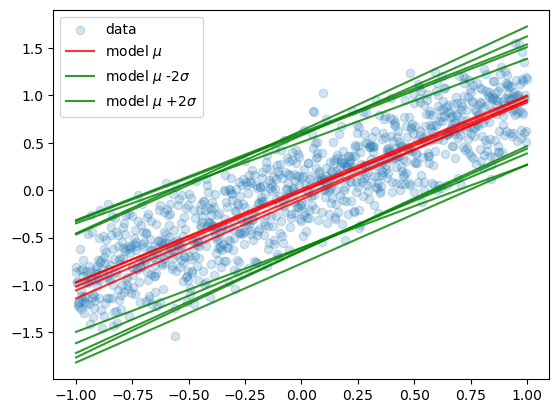

In [12]:
plt.scatter(x_train, y_train, alpha = 0.2, label = 'data')

for _ in range(5):
    y_model = model(x_train)
    y_hat = y_model.mean()
    y_cf1 = y_hat + 2 * y_model.stddev()
    y_cf2 = y_hat - 2 * y_model.stddev()
    
    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
        plt.plot(x_train, y_cf1, color='green', alpha=0.8, label='model $\mu$ -2$\sigma$')
        plt.plot(x_train, y_cf2, color='green', alpha=0.8, label='model $\mu$ +2$\sigma$')
    else:
        plt.plot(x_train, y_hat, color='red', alpha=0.8)
        plt.plot(x_train, y_cf1, color='green', alpha=0.8)
        plt.plot(x_train, y_cf2, color='green', alpha=0.8)
        
plt.legend()
plt.show()

Training a non-linear function
#### Use Sigmoid

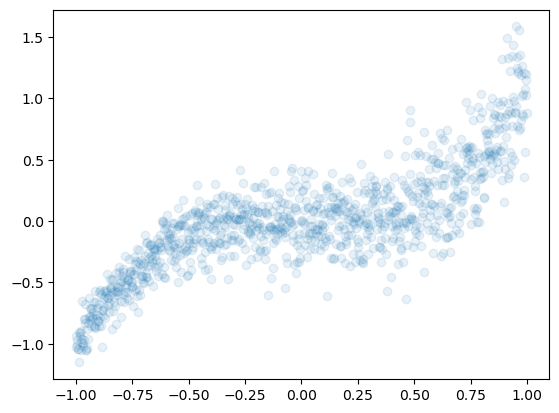

In [13]:
import numpy as np
x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + 0.1 * (2+x_train) * np.random.randn(1000)[:, np.newaxis]
plt.scatter(x_train, y_train, alpha=0.1)
plt.show()


In [14]:
model = Sequential([
    tfpl.DenseVariational(units = 6, 
                         input_shape = (1,),
                         make_prior_fn = prior,
                         make_posterior_fn = posterior,
                         kl_weight = 1/x_train.shape[0],
                         activation = 'sigmoid'),
    
    tfpl.DenseVariational(units = tfpl.IndependentNormal.params_size(1),
                         make_prior_fn = prior,
                         make_posterior_fn = posterior,
                         kl_weight = 1/x_train.shape[0]),
    tfpl.IndependentNormal(1)
])

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational_6 (DenseV  (None, 6)                90        
 ariational)                                                     
                                                                 
 dense_variational_7 (DenseV  (None, 2)                119       
 ariational)                                                     
                                                                 
 independent_normal_2 (Indep  ((None, 1),              0         
 endentNormal)                (None, 1))                         
                                                                 
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(x_train, y_train, epochs=1000, verbose=False)
model.evaluate(x_train, y_train)

32/32 [==============================] - 1s 1ms/step - loss: -0.0679


-0.06787507236003876

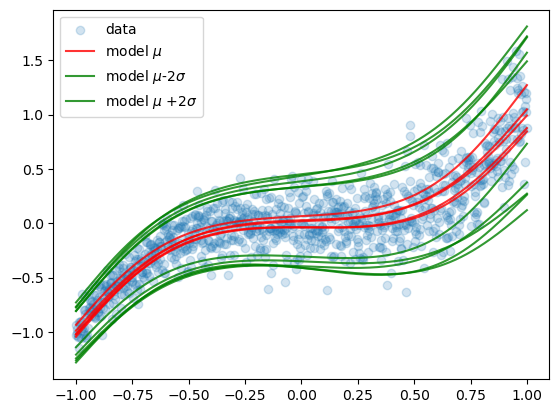

In [16]:
plt.scatter(x_train, y_train, alpha = 0.2, label = 'data')

for _ in range(5):
    y_model = model(x_train)
    y_hat = y_model.mean()
    y_cf1 = y_hat + 2 * y_model.stddev()
    y_cf2 = y_hat - 2 * y_model.stddev()
    
    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
        plt.plot(x_train, y_cf1, color='green', alpha=0.8, label='model $\mu$-2$\sigma$')
        plt.plot(x_train, y_cf2, color='green', alpha=0.8, label='model $\mu$ +2$\sigma$')
    else:
        plt.plot(x_train, y_hat, color='red', alpha=0.8)
        plt.plot(x_train, y_cf1, color='green', alpha=0.8)
        plt.plot(x_train, y_cf2, color='green', alpha=0.8)
        
plt.legend()
plt.show()